In [7]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anshbhardwaj1234","key":"8a11cdfcaf4a2a5ebbdc42d933a5caf8"}'}

In [8]:
!pip install --quiet kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip -q asl-alphabet.zip -d asl_data

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 99% 1.02G/1.03G [00:12<00:00, 237MB/s]
100% 1.03G/1.03G [00:12<00:00, 87.1MB/s]


In [14]:
import os
validation_split = 0.2
train_dir = 'asl_data/asl_alphabet_train/asl_alphabet_train/'
batch_size = 64
image_size = 64
target_dims = (image_size, image_size, 3)
num_classes = 29

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size    = 64
image_size    = 64
validation_split = 0.2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=validation_split
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

print("Classes found:", train_generator.class_indices)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Classes found: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


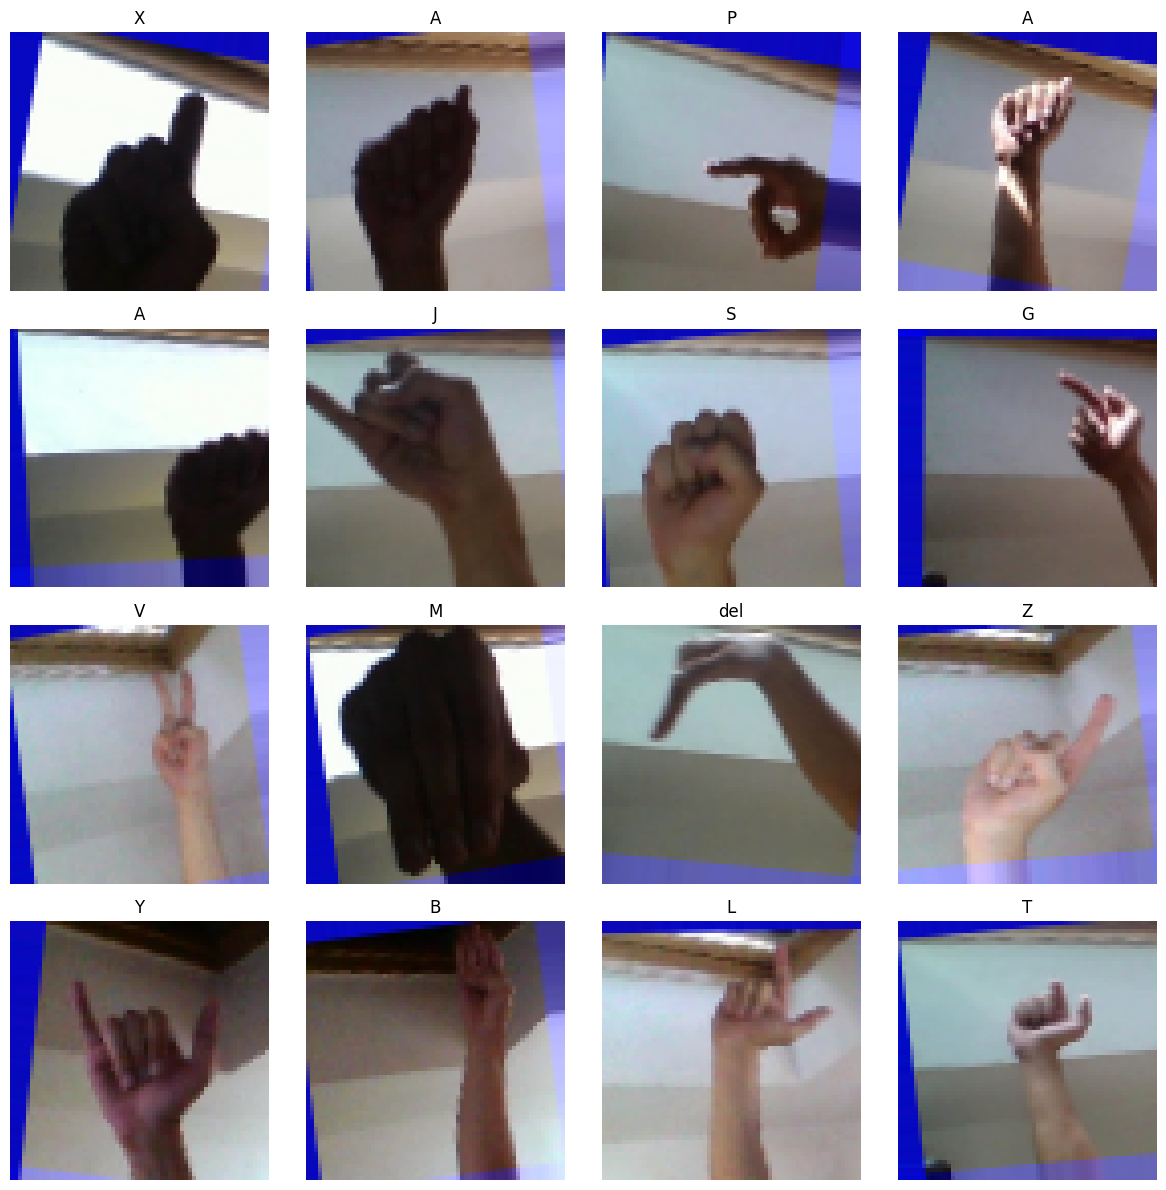

In [16]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)

inv_class = {v:k for k,v in train_generator.class_indices.items()}

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    img = x_batch[i]
    label_idx = y_batch[i].argmax()
    ax.imshow(img)
    ax.set_title(inv_class[label_idx])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [17]:
import os
import numpy as np
import string
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import skimage
from skimage.transform import resize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks    import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [18]:
# Cell 3: Model Definition (Custom Architecture)
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=target_dims))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,637 (1.36 MB)

 Trainable params: 356,637 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Cell 4: Compile Model

from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks    import EarlyStopping, ModelCheckpoint

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'asl_best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

my_callbacks = [early_stop, checkpoint]


In [21]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=my_callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3536 - loss: 2.2131

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 175s 157ms/step - accuracy: 0.3538 - loss: 2.2123 - val_accuracy: 0.5970 - val_loss: 1.3613
Epoch 2/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8722 - loss: 0.3985

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 169s 155ms/step - accuracy: 0.8722 - loss: 0.3984 - val_accuracy: 0.6913 - val_loss: 1.0671
Epoch 3/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 204s 157ms/step - accuracy: 0.9368 - loss: 0.1963 - val_accuracy: 0.7208 - val_loss: 1.0849
Epoch 4/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 174s 160ms/step - accuracy: 0.9571 - loss: 0.1329 - val_accuracy: 0.7307 - val_loss: 1.1722
Epoch 5/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 173s 159ms/step - accuracy: 0.9652 - loss: 0.1069 - val_accuracy: 0.7492 - val_loss: 1.0956
Epoch 6/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 170s 156ms/step - accuracy: 0.9733 - loss: 0.0836 - val_accuracy: 0.7129 - val_loss: 1.2745
Epoch 7/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 172s 158ms/step - accuracy: 0.9760 - loss: 0.0732 - val_accuracy: 0.7570 - val_loss: 1.1689


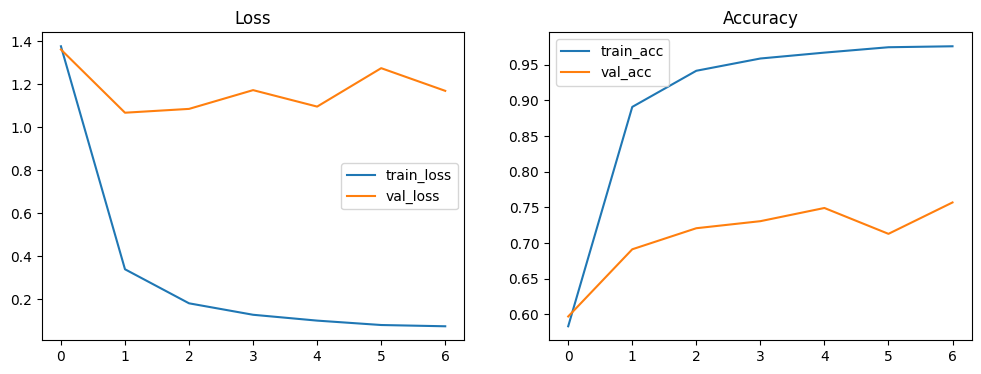

In [22]:
# Cell 7: Plot Training Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [23]:
# Cell 8: Evaluation on Validation Set
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')

272/272 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.7455 - loss: 0.9003
Validation loss: 1.0536, accuracy: 0.6932


In [ ]:

# Cell 9: Save Final Model
model.save('asl_colab.h5')
print('Model saved as asl_colab.h5')


Model saved as asl_alphabet_recognizer_colab.h5
